In [60]:
# create a neural network using pytorch with back propagation. The inputs are GloVe word embeddings and the output is the sentiment of the review (positive 1, negative -1)
# The hyperparameters are:
# the number of hidden layers, the number of neurons in each layer, the learning rate, the optimizer, the batch size, the activation function, the number of epochs
# The classifier is evaluated using precisionm recall and f1 score metrics from sklearn.metrics

# Path: project2.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score

inputFile = "../ergasia_1/imdb-reviews.csv"

df = pd.read_csv(inputFile, sep='\t')

positive = 0
negative = 0
neutral = 0

for index, row in df.iterrows():
    # if score is greater than 7, it is positive so change its value to 1, else -1
    if row["rating"] >= 7:
        positive += 1
        df.at[index, "rating"] = 1
    elif row["rating"] <= 4:
        negative += 1
        df.at[index, "rating"] = 0
    else:
        neutral += 1

# Get the GloVe word embeddings
gloveFile = "../glove.6B.50d.txt"

embeddings = {}
with open(gloveFile, 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings[word] = coefs

In [61]:
# Drop the first column (url)
df = df.drop(columns=['url'])

In [62]:
# Split the data into train 80% , test 15% and validation 5% sets

train = df.sample(frac=0.8, random_state=42)
test = df.drop(train.index)
test = test.sample(frac=0.75, random_state=42)
validation = df.drop(train.index)
validation = validation.drop(test.index)

# print df, train, test, validation sizes
print("df size: ", df.shape)
print("train size: ", train.shape)
print("test size: ", test.shape)
print("validation size: ", validation.shape)



df size:  (45008, 2)
train size:  (36006, 2)
test size:  (6752, 2)
validation size:  (2250, 2)


In [63]:
# Get X_train, y_train, X_test, y_test, X_validation, y_validation
X_train = train["review"]
y_train = train["rating"]
X_test = test["review"]
y_test = test["rating"]
X_validation = validation["review"]
y_validation = validation["rating"]


# Create word vectors for train, test and validation sets
def createWordVectors(data):
  wordVectors = [];
  for row in data:
    sum = np.zeros(len(embeddings["hello"]));
    word_count = 0;
    for word in row.split():
      if word in embeddings:
        sum = sum + embeddings[word];
        word_count = word_count+1;
    if word_count != 0:
      wordVectors.append(sum/word_count);
    else:
      wordVectors.append(np.zeros(len(embeddings["hello"])))

  wordVectors = np.array(wordVectors, dtype=np.float32)
  return wordVectors


X_train = createWordVectors(X_train)
X_test = createWordVectors(X_test)
X_validation = createWordVectors(X_validation)

# Convert the word vectors from ndarrays to tensors
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
X_validation = torch.tensor(X_validation, dtype=torch.float)

# Convert the labels to tensors
y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)
y_validation = torch.tensor(y_validation.values, dtype=torch.float)


In [64]:
#Print X_train type, the first element and its shape
print(type(X_train))
print(X_train.shape[1])
print(X_train[0])

#Print y_train type, the first element and its shape
print(type(y_train))
print(y_train[0].shape)
print(y_train[0])

<class 'torch.Tensor'>
50
tensor([ 3.7765e-01,  6.6619e-02, -3.5248e-03, -9.7917e-02,  3.9351e-01,
         2.1771e-01, -3.9907e-01, -1.4590e-01, -1.0825e-01, -5.3909e-02,
         5.6775e-02,  1.0920e-01, -3.2669e-01,  1.8710e-02,  3.7288e-01,
         1.9481e-01,  1.2883e-01,  8.5764e-02, -3.8893e-01, -3.4060e-01,
         4.9719e-02,  1.3341e-01,  1.5396e-01,  5.7593e-03,  1.5249e-01,
        -1.6376e+00, -4.3218e-01,  6.0406e-02,  2.1594e-01, -2.8825e-01,
         3.1539e+00,  4.8581e-04, -2.8266e-01, -3.6237e-01,  3.8935e-02,
         3.9828e-02,  7.1943e-02,  7.2923e-02,  3.3557e-02, -1.8043e-01,
        -1.5245e-01,  8.0433e-02, -2.6393e-03,  1.2572e-01, -2.2261e-04,
         5.6212e-02, -1.1243e-01, -1.6606e-01, -2.6841e-02, -9.8762e-02])
<class 'torch.Tensor'>
torch.Size([])
tensor(0.)


In [65]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
        # self.softmax = nn.Softmax(dim=D_out)

        
    def forward(self, x):
        h1 = self.linear1(x)
        h1 = F.relu(h1)

        h2 = self.linear2(h1)
        h2 = F.relu(h2)

        out = self.linear3(h2)

        return out

In [66]:
# Define layer sizes
D_in = X_train.shape[1]
H1 = 100
H2 = 50
D_out = 1

# Define hyperparameters
learning_rate = 1e-4

#Initialize model, loss, optimizer
model = Net(D_in, H1, H2, D_out)
loss_func = nn.MSELoss(reduction='sum')
# loss_func = nn.MSELoss(reduction='mean')
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate)


# Initialize dataloader
dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [67]:
model

Net(
  (linear1): Linear(in_features=50, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=1, bias=True)
)

In [68]:
# Train the model
epochs = 100

train_loss = []
val_loss = []

for epoch in range(epochs):
  batch_losses = []

  for x_batch, y_batch in dataloader:
    y_pred = model(x_batch)
    y_batch = y_batch.unsqueeze(-1)

    # print(y_pred.shape)
    # print(y_batch.shape)

    
    loss = loss_func(y_pred, y_batch)
    batch_losses.append(loss.item())
    
    # Delete previously stored gradients
    optimizer.zero_grad()
    # Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    # Update model's weights based on the gradients calculated during backprop
    optimizer.step()
  
  with torch.no_grad():
    Y_train_pred = model(X_train);
    loss_train = loss_func(Y_train_pred, y_train.unsqueeze(-1))/Y_train_pred.shape[0]
    train_loss.append(loss_train.item());
    y_val_pred = model(X_validation);
    loss_val = loss_func(y_val_pred, y_validation.unsqueeze(-1))/y_val_pred.shape[0]
    val_loss.append(loss_val.item());
  

  
  print(f"Epoch {epoch:3}: Loss = {sum(batch_losses)/len(dataloader):.5f}")


Epoch   0: Loss = 20.83786
Epoch   1: Loss = 15.42845
Epoch   2: Loss = 14.19951
Epoch   3: Loss = 12.78420
Epoch   4: Loss = 11.90126
Epoch   5: Loss = 11.46516
Epoch   6: Loss = 11.23163
Epoch   7: Loss = 11.09017
Epoch   8: Loss = 10.96165
Epoch   9: Loss = 10.85776
Epoch  10: Loss = 10.76562
Epoch  11: Loss = 10.68438
Epoch  12: Loss = 10.62681
Epoch  13: Loss = 10.56357
Epoch  14: Loss = 10.53877
Epoch  15: Loss = 10.47627
Epoch  16: Loss = 10.46784
Epoch  17: Loss = 10.42724
Epoch  18: Loss = 10.40036
Epoch  19: Loss = 10.36888
Epoch  20: Loss = 10.34338
Epoch  21: Loss = 10.32363
Epoch  22: Loss = 10.31246
Epoch  23: Loss = 10.28706
Epoch  24: Loss = 10.26520
Epoch  25: Loss = 10.24607
Epoch  26: Loss = 10.22562
Epoch  27: Loss = 10.20953
Epoch  28: Loss = 10.20042
Epoch  29: Loss = 10.19090
Epoch  30: Loss = 10.15945
Epoch  31: Loss = 10.16845
Epoch  32: Loss = 10.14250
Epoch  33: Loss = 10.13194
Epoch  34: Loss = 10.11630
Epoch  35: Loss = 10.12279
Epoch  36: Loss = 10.08873
E

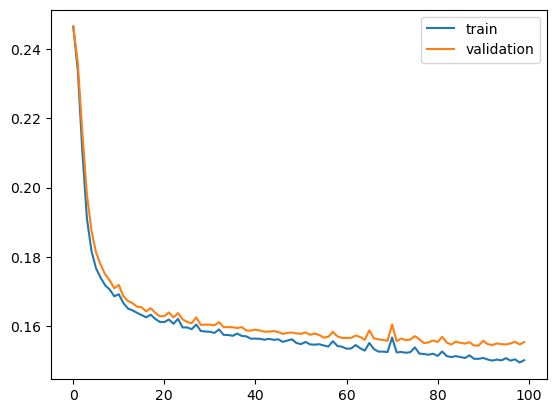

In [69]:
# Plot the learning curves for train and validation sets
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend()
plt.show()


In [79]:
# Calculate the precision, recall and f1 score
def calculate_metrics(y_true, y_pred):
    y_true = y_true.detach().numpy()
    y_pred = y_pred.detach().numpy()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

# Print the metrics for the train, test and validation sets
def print_metrics(y_true, y_pred, title):
    precision, recall, f1 = calculate_metrics(y_true, y_pred)
    print(f"{title:10} --> Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# Print the metrics for the train set
y_pred = model(X_train)
print_metrics(y_train, y_pred, "Train")

# Print the metrics for the test set
y_pred = model(X_test)
print_metrics(y_test, y_pred, "Test")

# Print the metrics for the validation set
y_pred = model(X_validation)
print_metrics(y_validation, y_pred, "Validation")


Train      --> Precision: 0.800, Recall: 0.749, F1: 0.774
Test       --> Precision: 0.802, Recall: 0.744, F1: 0.772
Validation --> Precision: 0.799, Recall: 0.746, F1: 0.771


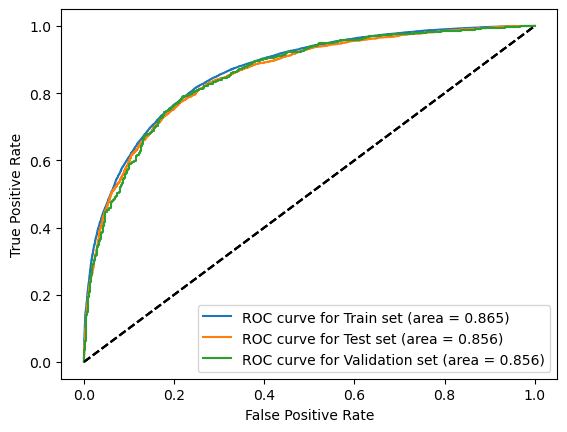

In [82]:
# Print ROC curves for train, test and validation sets on the same plot

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true.detach(), y_pred.detach())
    plt.plot(fpr, tpr, label=f"ROC curve for {title} set (area = {auc(fpr, tpr):.3f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

# Plot the ROC curve for the train set
y_pred = model(X_train)
plot_roc_curve(y_train, y_pred, "Train")

# Plot the ROC curve for the test set
y_pred = model(X_test)
plot_roc_curve(y_test, y_pred, "Test")

# Plot the ROC curve for the validation set
y_pred = model(X_validation)
plot_roc_curve(y_validation, y_pred, "Validation")

plt.show()